## Helper Functions and Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def relu(Z):
    R = np.maximum(0, Z)
    return R

def sigmoid(Z):
    S = 1 / (1 + np.exp(-1 * Z))
    return S

def relu_derivative(Z):
    Z[Z >= 0] = 1
    Z[Z < 0]  = 0
    return Z

def sigmoid_derivative(Z):
    SD = sigmoid(Z) * (1 - sigmoid(Z))
    return SD

## NN Model

In [2]:
class model():
    
    layers = []
    L = 0
    W = {}
    b = {}
    A = {}
    Z = {}
    dA = {}
    dZ = {}
    dW = {}
    db = {}
    cost = 0.
    m = 0
    lam = 0
    cost_history = []
    acc_history = []
    alpha_history = []
    alpha = 0.
    iterations = 0
    
    def __init__(self):
        
        self.layers = []
        self.L = 0
        self.W = {}
        self.b = {}
        self.A = {}
        self.Z = {}
        self.dA = {}
        self.dZ = {}
        self.dW = {}
        self.db = {}
        self.cost = 0.
        self.m = 0
        self.lam = 0
        self.cost_history = []
        self.acc_history = []
        self.alpha_history = []
        self.alpha = 0.
        self.iterations = 0

        return
    
    def add_layers(self, list_of_layers):
        
        self.layers = list_of_layers
        self.L = len(self.layers) - 1 # Number of layers excluding the input feature layer
        
        return
    
    def init_params(self):
        
        for i in range(1, self.L + 1):
            self.W[str(i)] = np.random.randn(self.layers[i], self.layers[i - 1]) * np.sqrt(2. / self.layers[i - 1])
            self.b[str(i)] = np.zeros((self.layers[i], 1))
            
        return
    
    def forward_prop(self, X):
        
        self.A['0'] = X
        
        for i in range(1, self.L + 1):
            self.Z[str(i)] = np.dot(self.W[str(i)], self.A[str(i - 1)]) + self.b[str(i)]
            if i == self.L:
                # Output layer, Sigmoid activation
                self.A[str(i)] = sigmoid(self.Z[str(i)])
            else:
                # Hidden layer, Relu activataion
                self.A[str(i)] = relu(self.Z[str(i)])
        
        return
    
    def compute_cost(self, Y):
        
        self.cost = -1 * np.sum(np.multiply(Y, np.log(self.A[str(self.L)])) + 
                           np.multiply(1 - Y, np.log(1 - self.A[str(self.L)]))) / self.m 
        
        if self.lam != 0:
            reg = (self.lam / (2 * self.m))
            for i in range(1, self.L + 1):
                reg += np.sum(np.dot(self.W[str(i)], self.W[str(i)].T))
            self.cost += reg
            
        self.cost_history.append(self.cost)
        
        return
    
    def backward_prop(self, Y):
        
        # We need dA[str(L)] to start the backward prop computation
        self.dA[str(self.L)] = -1 * (np.divide(Y, self.A[str(self.L)]) - np.divide(1 - Y, 1 - self.A[str(self.L)]))
        self.dZ[str(self.L)] = np.multiply(self.dA[str(self.L)], sigmoid_derivative(self.Z[str(self.L)]))
        self.dW[str(self.L)] = np.dot(self.dZ[str(self.L)], self.A[str(self.L - 1)].T) / self.m + (self.lam/self.m) * self.W[str(self.L)]
        self.db[str(self.L)] = np.sum(self.dZ[str(self.L)], axis = 1, keepdims = True) / self.m
        self.dA[str(self.L - 1)] = np.dot(self.W[str(self.L)].T, self.dZ[str(self.L)])
            
        for i in reversed(range(1, self.L)):

            self.dZ[str(i)] = np.multiply(self.dA[str(i)], relu_derivative(self.Z[str(i)]))
            self.dW[str(i)] = np.dot(self.dZ[str(i)], self.A[str(i - 1)].T) / self.m + (self.lam/self.m) * self.W[str(i)]
            self.db[str(i)] = np.sum(self.dZ[str(i)], axis = 1, keepdims = True) / self.m
            self.dA[str(i - 1)] = np.dot(self.W[str(i)].T, self.dZ[str(i)])
        
        return
    
    def update_params(self):
        
        for i in range(1, self.L + 1):
            self.W[str(i)] = self.W[str(i)] - self.alpha * self.dW[str(i)]
            self.b[str(i)] = self.b[str(i)] - self.alpha * self.db[str(i)]
        
        return
    
    def train(self, X, Y, iterations = 10, 
        alpha = 0.001, decay = True, decay_iter = 5, decay_rate = 0.9, stop_decay_counter = 100,
        verbose = True, lam = 0):
        
        self.m = Y.shape[1]
        self.alpha = alpha
        self.iterations = iterations
        self.lam = lam
        
        # initialize parameters
        self.init_params()

        for i in range(iterations):
            # forward prop
            self.forward_prop(X)
            # compute cost
            self.compute_cost(Y)
            # backward prop
            self.backward_prop(Y)
            # update params
            self.update_params()
            # evaluate
            self.acc_history.append(self.evaluate(X, Y, in_training = True))
            # save alpha
            self.alpha_history.append(self.alpha)
            # learning rate decay
            if decay and stop_decay_counter > 0 and i % decay_iter == 0:
                self.alpha = decay_rate * self.alpha
                stop_decay_counter -= 1
            # display cost per iteration
            if verbose:
                print('Cost after {} iterations: {}'.format(i, self.cost))
        
        return
    
    def predict(self, X, in_training = False):
        
        if in_training == False:
            self.forward_prop(X)
            
        preds = self.A[str(self.L)] >= 0.5
        preds = np.squeeze(preds)
        
        return preds
        
    def evaluate(self, X, Y, in_training = False):
        
        examples = X.shape[1]
        
        pred = self.predict(X, in_training = in_training)
        pred = pred.reshape(1, examples)
        diff = np.sum(abs(pred - Y))
        acc = (examples - np.sum(diff)) / examples
        
        return acc
    
    def plot_cost(self):
        
        plt.plot(range(self.iterations), self.cost_history, color = 'b')
        plt.show()
        
        return
    
    def plot_acc(self):
        
        plt.plot(range(self.iterations), self.acc_history, color = 'r')
        plt.show()
        
        return
    
    def plot_alpha(self):
        
        plt.plot(range(self.iterations), self.alpha_history, color = 'g')
        plt.show()
        
        return

## MNIST Dataset
Let's make the NN recognise just two digits: 0 and 1

In [3]:
from tensorflow.python.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train / 255.
X_test = X_test / 255.

training_indices_for_0 = Y_train == 0
length = len(Y_train[Y_train == 0])

X_train_0 = np.zeros((length, 28, 28))
Y_train_0 = np.zeros((length, 1))

count = 0

for i in range(training_indices_for_0.shape[0]):
    if training_indices_for_0[i]:
        X_train_0[count] = X_train[i]
        Y_train_0[count] = Y_train[i]
        count += 1

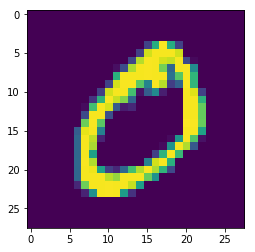

In [4]:
plt.imshow(X_train_0[0])

In [5]:
training_indices_for_1 = Y_train == 1
length = len(Y_train[Y_train == 1])

X_train_1 = np.zeros((length, 28, 28))
Y_train_1 = np.zeros((length, 1))

count = 0

for i in range(training_indices_for_1.shape[0]):
    if training_indices_for_1[i]:
        X_train_1[count] = X_train[i]
        Y_train_1[count] = Y_train[i]
        count += 1

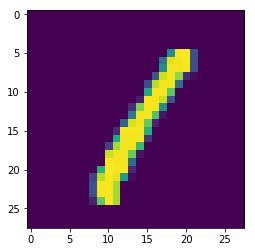

In [6]:
plt.imshow(X_train_1[0])

In [7]:
# Combine and shuffle the two
X = np.vstack((X_train_0, X_train_1))
Y = np.vstack((Y_train_0, Y_train_1))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)
X_test_original = X_test

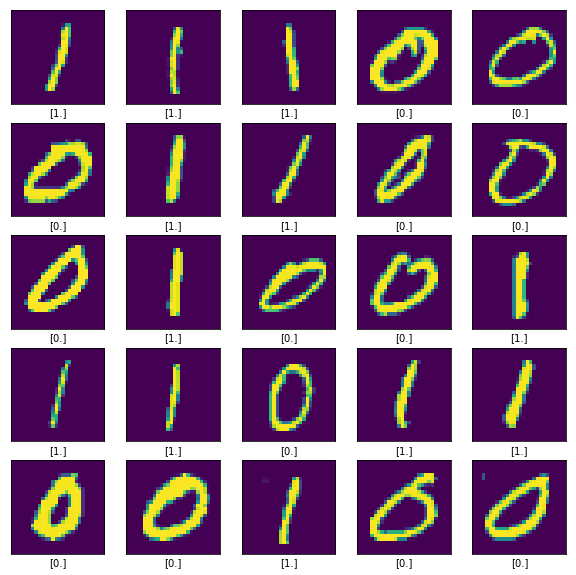

In [9]:
# Let's look at some of the images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(str(y_train[i]))

In [10]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [11]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

In [17]:
m_mnist = model()
m_mnist.add_layers([X_train.shape[0], 64, 64, 1])

m_mnist.train(
    X_train, y_train, iterations = 60, 
    alpha = 0.003, decay = True, decay_iter = 5, 
    decay_rate = 0.96, stop_decay_counter = 100,
    verbose = False, lam = 4
)

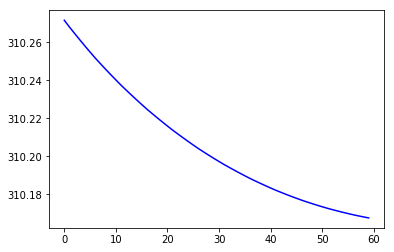

In [18]:
m_mnist.plot_cost()

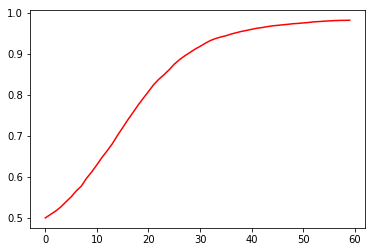

In [19]:
m_mnist.plot_acc()

In [20]:
print(m_mnist.evaluate(X_test, y_test))

0.9881563363600474


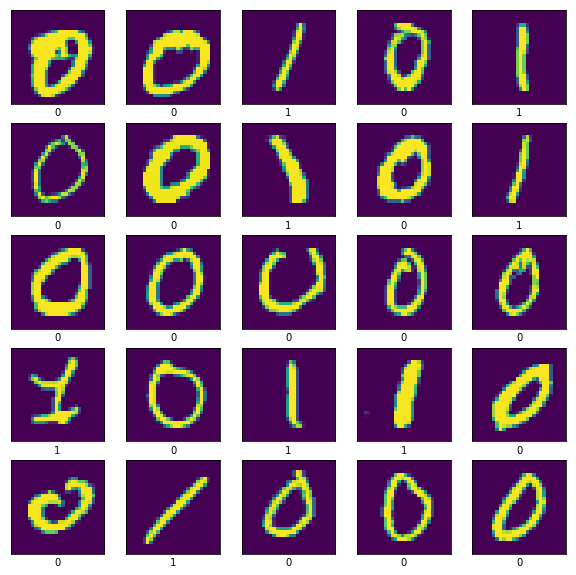

In [21]:
# Let's look at predictions
preds = m_mnist.predict(X_test)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_original[i])
    plt.xlabel(int(preds[i]))